# Guided Project #6 - Analyzing NYC High School Data
By [Luis Munguia](http://www.linkedin.com/in/luis-munguia) and [Dataquest](http://www.dataquest.io)

In this guided project, I'll work with data sets published by New York City on student SAT scores by high school and additional demographic data.

The fist step in this guided project is everything I needed to do in order to produce a single dictionary pandas dataframe of:

* SAT scores by school - SAT scores for each high school in New York City
* School attendance - Attendance information for each school in New York City
* Class size - Information on class size for each school
* AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* Graduation outcomes - The percentage of students who graduated, and other outcome information
* Demographics - Demographic information for each school
* School survey - Surveys of parents, teachers, and students at each school

The purpose of this project is to find any relatioships between demographic factos such as race, income and gender with SAT score, in order to determine if SAT is a fair test. If I find that certain racial groups consistently perform better, I would have evidence that SAT is unfair.

## 0.- Combine all databases into one and do correlations.

Use pandas to import data from `csv` files and combine everthing into a single data frame.

### Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## 1.- Set up matplotlib and plot correlations.

Use Jupiter magic commands and make bar plot of correlations between the survey of parents, teachers and studens and `sat_score`.

In [11]:
%matplotlib inline

We can make the selection of a correlation series and splice it with a list as follows:

In [12]:
combined.corr()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.986820,0.490283,0.483479,0.441813,0.289710,0.035699,0.357418,...,NaN,NaN,-0.064120,0.367945,0.111556,NaN,NaN,NaN,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.972643,0.545646,0.533239,0.469456,0.379012,0.078078,0.444985,...,NaN,NaN,-0.033971,0.460646,0.134403,NaN,NaN,NaN,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.987771,0.501648,0.495321,0.451790,0.282701,0.009161,0.353928,...,NaN,NaN,-0.093174,0.366308,0.096834,NaN,NaN,NaN,-0.100551,-0.143850
sat_score,0.986820,0.972643,0.987771,1.000000,0.523140,0.514333,0.463245,0.325144,0.042948,0.394626,...,NaN,NaN,-0.063977,0.407827,0.117012,NaN,NaN,NaN,-0.121029,-0.132222
AP Test Takers,0.490283,0.545646,0.501648,0.523140,1.000000,0.992192,0.901513,0.602802,0.091956,0.699954,...,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121
Total Exams Taken,0.483479,0.533239,0.495321,0.514333,0.992192,1.000000,0.930634,0.558005,0.073661,0.662042,...,NaN,NaN,0.055484,0.640075,0.143048,NaN,NaN,NaN,-0.092747,-0.060357
Number of Exams with scores 3 4 or 5,0.441813,0.469456,0.451790,0.463245,0.901513,0.930634,1.000000,0.383447,0.009065,0.503843,...,NaN,NaN,0.034659,0.461334,-0.002438,NaN,NaN,NaN,-0.049501,-0.036566
Total Cohort,0.289710,0.379012,0.282701,0.325144,0.602802,0.558005,0.383447,1.000000,0.268492,0.918767,...,NaN,NaN,0.159297,0.919198,0.642994,NaN,NaN,NaN,-0.173088,-0.003523
CSD,0.035699,0.078078,0.009161,0.042948,0.091956,0.073661,0.009065,0.268492,1.000000,0.243370,...,NaN,NaN,0.812558,0.278267,0.287908,NaN,NaN,NaN,-0.530901,0.318252
NUMBER OF STUDENTS / SEATS FILLED,0.357418,0.444985,0.353928,0.394626,0.699954,0.662042,0.503843,0.918767,0.243370,1.000000,...,NaN,NaN,0.148213,0.947036,0.619696,NaN,NaN,NaN,-0.169959,-0.036394


The above dataframe contains all the correlations between all variables and series.

In [13]:
combined.corr()["sat_score"]

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

The above series contains all the correlations between all variables.

In [14]:
combined.corr()["sat_score"][survey_fields]

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

The above series has been sliced with the mentioned list. There is two way to do the bar plot. Using a shortcut or using the complete code.

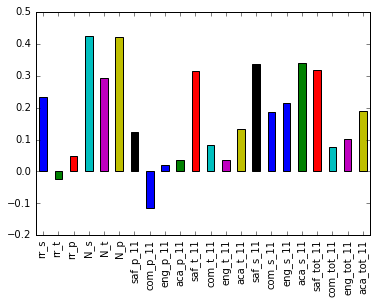

In [15]:
correlations[survey_fields].plot.bar() #This is the shortcut

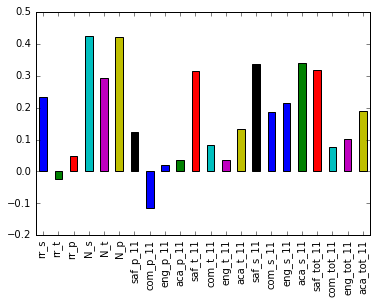

In [16]:
combined.corr()["sat_score"][survey_fields].plot.bar() #This is the code

The variables with the largest correlations are:

* N_s: Number of student respondents
* N_t: Number of teacher respondents
* N_p: Number of parent respondents
* saf_t_11: Safety and Respect score based on teacher responses
* saf_s_11: Safety and Respect score based on student responses
* aca_s_11: Academic expectations score based on student responses
* saf_tot_11: Safety and Respect total score

The variables with the lowest correlations are:

* com_p_11: Communication score based on parent responses

According to the findings above, it seems that schools were students, teachers and parents participate in school related activities (such as answering a school survey) tend to have better SAT scores.
Also, the perception of safety by students and teachers is a good indicator of higher SAT scores.
Finally, schools where parents believe the communication is poor have low SAT scores.

## 2.- Investigate and map safety scores.

Make scatter plot of `saf_s_11` vs `sat_score` and map out safety scores by New York City boroughs.

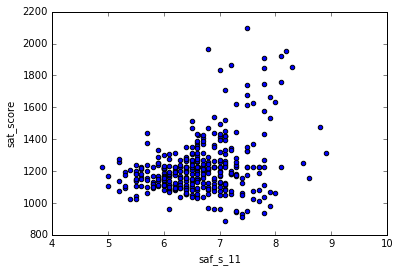

In [17]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

In [18]:
combined["saf_s_11"].value_counts().sort_index()

4.900000     1
5.000000     2
5.200000     4
5.300000     4
5.400000     2
5.500000    10
5.600000     7
5.700000     8
5.800000     8
5.900000    11
6.000000    23
6.100000    20
6.200000    13
6.300000    12
6.400000    29
6.500000    21
6.600000    25
6.611667     3
6.700000    16
6.800000    16
6.900000    16
7.000000    20
7.100000    20
7.200000     9
7.300000    11
7.400000     6
7.500000    11
7.600000     5
7.700000     5
7.800000    10
7.900000     4
8.000000     2
8.100000     3
8.200000     1
8.300000     1
8.500000     1
8.600000     1
8.800000     1
8.900000     1
Name: saf_s_11, dtype: int64

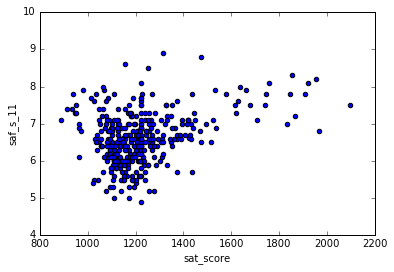

In [19]:
combined.plot.scatter(x="sat_score", y="saf_s_11")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cb1ba8c18>,
      dtype=object)

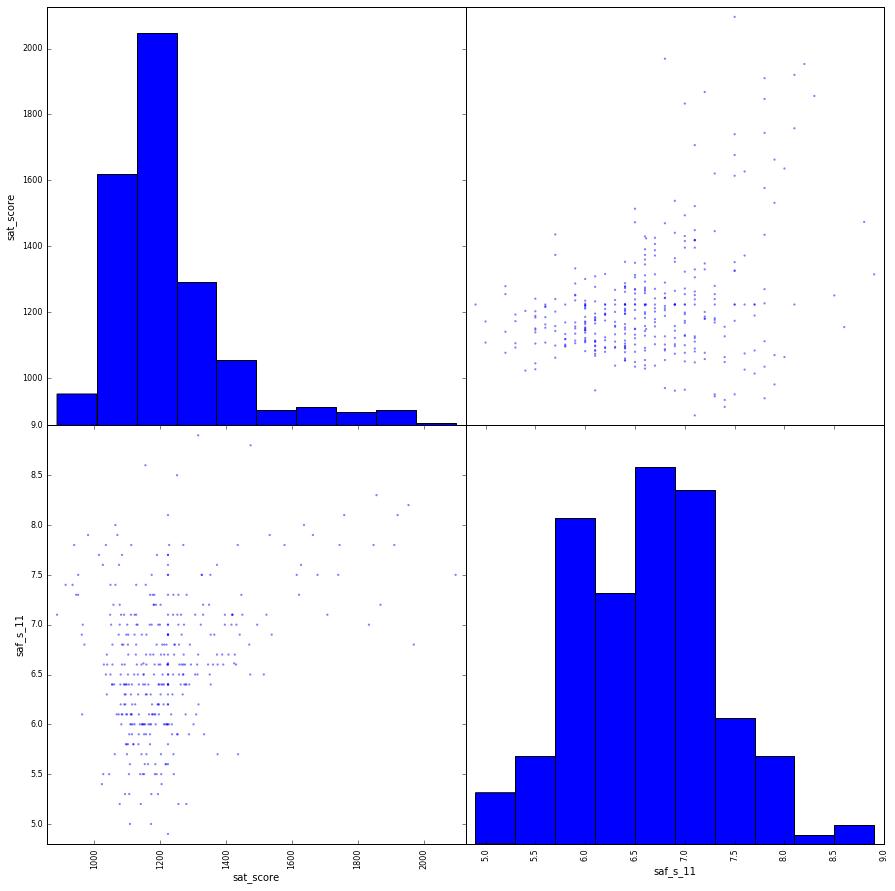

In [20]:
from pandas.plotting import scatter_matrix
scatter_matrix(combined[['sat_score', 'saf_s_11']], figsize=(15,15))

According to the plots above, the perception of safety grades heavily on SAT scores. Lets map out these safety scores to see how New York holds up. First let us do averages for all districs.

In [21]:
districts = combined.groupby("school_dist").agg(numpy.mean)

In [22]:
districts

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,139.041709,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,97.597416,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,129.765099,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,100.118588,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240


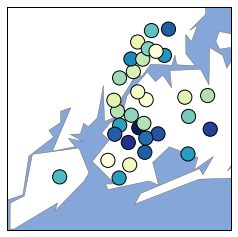

In [23]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=200, 
          zorder=2, latlon=True, c=districts["saf_s_11"], cmap="YlGnBu_r")

It seems that mostly everything above Brooklyn has good safety scores. (Blue is low scores, Yellow is High Scores. I'm colorblind so it was difficult to choose a color scheme that worked for me.)

## 3.- Determine Racial Differences in SAT Performance

Plot correlations between `white_per`, `asian_per`, `black_per` and `hispanic_per`.

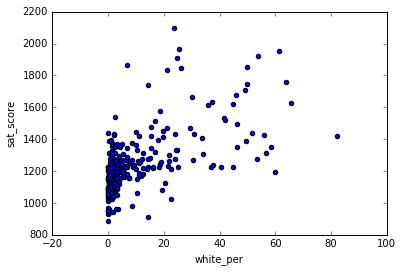

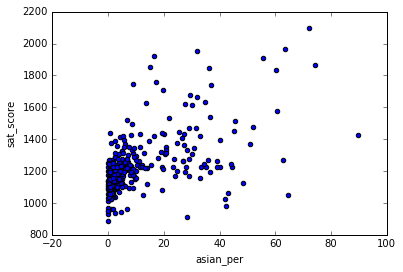

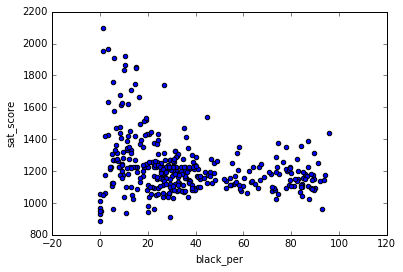

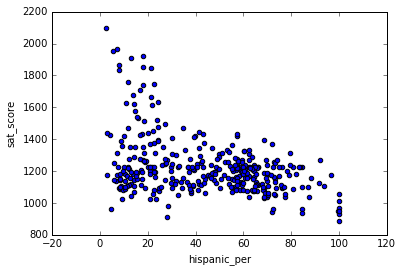

In [24]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]

for i in races:
    combined.plot.scatter(x=i, y="sat_score")

Schools with White and Asian race majority seem to do much better on SAT scores. Let us see the correlation in one plot.

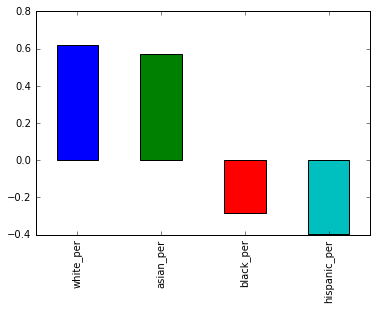

In [25]:
combined.corr()["sat_score"][races].plot.bar()

When talking about high SAT scores, there is extremely high positive correlation with White and Asian races, and mild negative correlation with Black and Asian races.

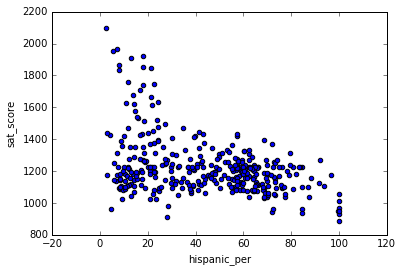

In [26]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

In [27]:
combined[combined["hispanic_per"] > 95]["school_name"]

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

These schools are for inmigrants that want to study in the US or are studying english. This may be the reason they receive low grades in the SAT Score.

In [28]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["school_name"]

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

These schools are centered on science and technology, which would explain its SAT high scores, but it does not explain why there is a low hispanic_percentage. Let see what is the percentage in those schools.

In [29]:
combined[(combined["hispanic_per"] < 10) & (
    combined["sat_score"] > 1800)][["school_name","white_per", "asian_per", "black_per", "hispanic_per"]]

,school_name,white_per,asian_per,black_per,hispanic_per
37,Stuyvesant High School,23.7,72.1,1.2,2.4
151,Bronx High School of Science,25.4,63.5,3.5,7.2
187,Brooklyn Technical High School,21.3,60.3,10.2,7.9
327,Queens High School for the Sciences at York Co...,6.7,74.4,10.5,7.9
356,Staten Island Technical High School,61.3,31.8,1.1,5.3


This is interesting, as almost all of the schools have high asian percentaje.

## 4.- Determine Gender Differences in SAT Performance

Plot correlations between `male_per` and `female_per`.

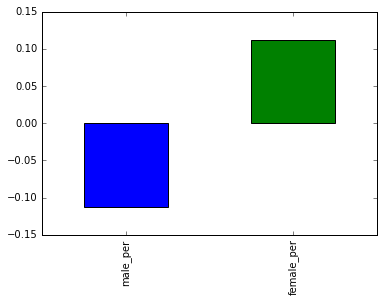

In [30]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

Neither correlation is strong, but gives us insight that high percentage of females positively correlate with SAT scores. Let's explore this further.

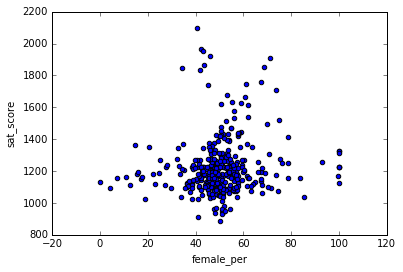

In [31]:
combined.plot.scatter(x="female_per", y="sat_score")

It seems that having between 50 to 80 percentage of females in a highschool produces better SAT scores.

In [32]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["school_name"]

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools are liberal art schools that rigorously teach their students to think critically.

## 5.- Determine Advanced Placement Correlation with SAT Performance

Plot correlations between `AP Test Takers ` and `sat_score`. Because `total_enrollment` is highly correlated with `sat_score` I will use the percetage of students in each school who took the AP exam instead to avoid bias.

In [33]:
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


In [34]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

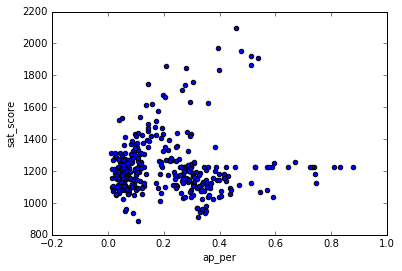

In [35]:
combined.plot.scatter(x="ap_per", y="sat_score")

There doesn't seem to be a strong correlation between these 2 variables.

## 6.- Guided Project Next Steps.

### Determine Correlation between class size and SAT scores.

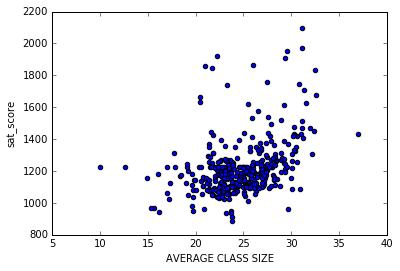

In [36]:
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")

I would have never imagined that having average class size above 25 would translate in overall better SAT score. I thought that classes with less students had better grades.

### Figuring out which neighborhood have the best schools.

In [37]:
best_schools = combined[combined["sat_score"] > 1300][["school_name", "boro", "city", "state_code", "zip", "Location 1", "school_dist"]]
best_schools.head()

,school_name,boro,city,state_code,zip,Location 1,school_dist
4,"New Explorations into Science, Technology and ...",Manhattan,New York,NY,10002,"111 Columbia Street\nNew York, NY 10002\n(40.7...",01
5,Bard High School Early College,Manhattan,New York,NY,10002,"525 East Houston Street\nNew York, NY 10002\n(...",01
17,NYC iSchool,Manhattan,New York,NY,10013,"131 Avenue Of The Americas\nNew York, NY 10013...",02
21,High School for Environmental Studies,Manhattan,New York,NY,10019,"444 West 56 Street\nNew York, NY 10019\n(40.76...",02
22,Professional Performing Arts High School,Manhattan,New York,NY,10036,"328 West 48 Street\nNew York, NY 10036\n(40.76...",02


Sometimes the city value here is the neighboorhood! But sadly a lot of values are New York.

In [38]:
best_schools["boro"].value_counts().sort_index()

Bronx             5
Brooklyn         16
Manhattan        26
Queens           20
Staten Island     6
Name: boro, dtype: int64

Manhattan and Queens have the largest number of best schools. But what percentage of total schools do they represent?

In [39]:
combined["boro"].value_counts().sort_index()

Bronx             93
Brooklyn         106
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

In [40]:
26/90

0.28888888888888886

In [41]:
20/64

0.3125

Almost 30% of the schools in Manhattan and Queens are high performing schools.

### Investigation the differences between parent, teacher and student responses to surveys.

In [42]:
survey_answers = combined[survey_fields]

In [43]:
survey_answers

,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,...,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,7.2,7.3,...,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,8.1,8.4,...,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,7.2,7.3,...,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,7.9,8.4,...,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8
5,98.0,81,50,561.000000,30.0,283.0,8.8,8.2,8.3,9.1,...,7.5,8.3,8.300000,7.300000,8.000000,8.900000,8.5,7.6,8.0,8.7
6,72.0,76,30,109.000000,16.0,43.0,8.9,7.7,7.9,8.1,...,7.7,7.2,7.300000,6.300000,7.000000,7.500000,8.1,6.7,7.5,7.6
7,86.0,100,57,348.000000,35.0,229.0,7.6,7.0,6.9,7.6,...,7.8,7.7,6.200000,5.700000,6.100000,7.200000,7.0,6.6,6.9,7.5
8,48.0,56,9,150.000000,15.0,28.0,8.7,8.1,7.9,8.3,...,7.9,8.9,7.400000,6.500000,7.300000,7.600000,7.9,7.3,7.7,8.2
9,61.0,96,56,233.000000,27.0,204.0,8.0,7.3,7.1,7.5,...,8.7,8.9,7.100000,6.500000,7.000000,7.400000,7.9,7.3,7.6,8.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cac3e96d8>,
      dtype=object)

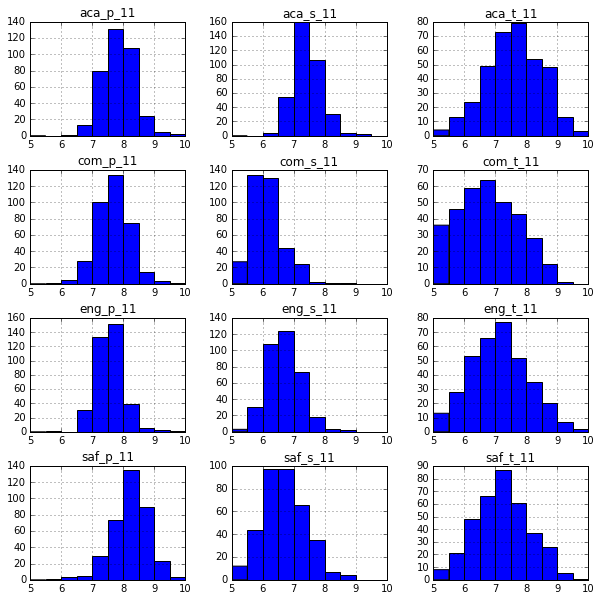

In [44]:
survey_answers[["saf_p_11","com_p_11", "eng_p_11", "aca_p_11",
               "saf_t_11","com_t_11", "eng_t_11", "aca_t_11",
               "saf_s_11","com_s_11", "eng_s_11", "aca_s_11"]].hist(
               figsize=(10,10), layout=(4,3), range=(5,10), bins=10)

ACA = Academic expectations

COM = Communication

ENG = Engagement

SAF = Safety and Respect

It's worth mentioning that the values of each group for each category is constant in all cases. I was not able to set the Y limit with this code.

## 10.- Closing Commentary

These are my findings after reviewing and analyzing the New York City school data sets:
* Schools where people are more willing to participate in school related activities have higher SAT Scores.
* The perception of safety by teachers and students affect the SAT score.
* Schools where parents believe the communication is poor have low SAT scores.
* Schools located geographically to the north of Brooklyn have good safety scores.
* Schools with higher percentage of white and asians have higher SAT scores.
* Schools with higher percentage of females have higher SAT scores.
* Schools where students are doing AP tests do not necessarily indicate higher SAT scores.
* Schools where the average class size above 25 tend to have better SAT scores.
* Almost 30% of the schools in Manhattan and Queens are high performing schools.


Take aways:
* Increase federal funding in Bronx and Brooklyn to improve education.
* Increase federal funding in all areas to improve safety.
* Invite parents and keep them comunicated to improve schools.
* Improve education of hispanic and blacks.
* Set 25 as the standard for class size.

Is SAT a fair test? Is there any evidence to say it's not?

According to my analysis, it seems some races consistently perfom better, but I was not able to determine the reason with the data set provided. I would need to include more data, for example the whole country, to better determine the reasons the scores seem to favor one race over other.